In [58]:
# load dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
import numpy as np
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [59]:
tx_energy = pd.read_csv("texas_energy_production.csv")  #usecols=[1],engine='python'
# texas_energy.set_index('Years', inplace=True)
tx_energy.head()

,Years,Coal_prod,Gas_prod,Oil_prod,Renewable_en_prod,Total_en_prod
0,1960,26409,6602696,5379378,50155,12058639
1,1961,26535,6682140,5447308,52023,12208006
2,1962,25855,6812787,5471272,47721,12357635
3,1963,27441,6952455,5671135,42718,12693749
4,1964,28839,7311876,5739216,43884,13123816


# Texas Coal forcast model 

In [60]:
tx_coal = tx_energy[["Coal_prod"]]
tx_coal.head()
# tx_coal.shape

,Coal_prod
0,26409
1,26535
2,25855
3,27441
4,28839


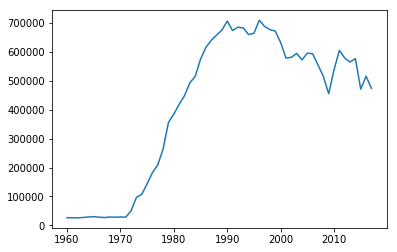

In [61]:
plt.plot(tx_energy.Years,tx_coal.Coal_prod)

In [62]:
tx_coal = tx_coal.values
tx_coal = tx_coal.astype('float32')

In [63]:
scaler = MinMaxScaler(feature_range=(0, 1))
tx_coal = scaler.fit_transform(tx_coal)

In [64]:
# split into train and test sets
train_size = int(len(tx_coal) * 0.67)
test_size = len(tx_coal) - train_size
train, test = tx_coal[0:train_size,:], tx_coal[train_size:len(tx_coal),:]

In [65]:
# convert an array of values into a dataset matrix
def create_dataset(state_data, look_back=1):
	dataX, dataY = [], []
	for i in range(len(state_data)-look_back-1):
		a = state_data[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(state_data[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [66]:
# reshape into X=t and Y=t+1
look_back= 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [67]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [68]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 2s - loss: 0.4312
Epoch 2/100
 - 0s - loss: 0.3881
Epoch 3/100
 - 0s - loss: 0.3524
Epoch 4/100
 - 0s - loss: 0.3198
Epoch 5/100
 - 0s - loss: 0.2930
Epoch 6/100
 - 0s - loss: 0.2675
Epoch 7/100
 - 0s - loss: 0.2459
Epoch 8/100
 - 0s - loss: 0.2260
Epoch 9/100
 - 0s - loss: 0.2091
Epoch 10/100
 - 0s - loss: 0.1933
Epoch 11/100
 - 0s - loss: 0.1800
Epoch 12/100
 - 0s - loss: 0.1686
Epoch 13/100
 - 0s - loss: 0.1577
Epoch 14/100
 - 0s - loss: 0.1483
Epoch 15/100
 - 0s - loss: 0.1410
Epoch 16/100
 - 0s - loss: 0.1330
Epoch 17/100
 - 0s - loss: 0.1260
Epoch 18/100
 - 0s - loss: 0.1200
Epoch 19/100
 - 0s - loss: 0.1142
Epoch 20/100
 - 0s - loss: 0.1094
Epoch 21/100
 - 0s - loss: 0.1038
Epoch 22/100
 - 0s - loss: 0.0990
Epoch 23/100
 - 0s - loss: 0.0943
Epoch 24/100
 - 0s - loss: 0.0892
Epoch 25/100
 - 0s - loss: 0.0846
Epoch 26/100
 - 0s - loss: 0.0799
Epoch 27/100
 - 0s - loss: 0.0753
Epoch 28/100
 - 0s - loss: 0.0704
Epoch 29/100
 - 0s - loss: 0.0659
Epoch 30/100
 - 0s - lo

In [69]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [70]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 24698.35 RMSE
Test Score: 56684.62 RMSE


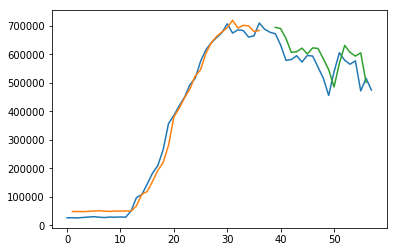

In [71]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(tx_coal)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(tx_coal)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(tx_coal)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(tx_coal))
plt.plot(trainPredictPlot)

plt.plot(testPredictPlot)
plt.show()

In [72]:
# re-train the LSTM on all data
look_back = 30 # look back further
trainX, trainY = create_dataset(tx_coal, look_back)
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

# re-create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 3s - loss: 0.2758
Epoch 2/100
 - 0s - loss: 0.0700
Epoch 3/100
 - 0s - loss: 0.0287
Epoch 4/100
 - 0s - loss: 0.0219
Epoch 5/100
 - 0s - loss: 0.0166
Epoch 6/100
 - 0s - loss: 0.0126
Epoch 7/100
 - 0s - loss: 0.0098
Epoch 8/100
 - 0s - loss: 0.0076
Epoch 9/100
 - 0s - loss: 0.0066
Epoch 10/100
 - 0s - loss: 0.0057
Epoch 11/100
 - 0s - loss: 0.0050
Epoch 12/100
 - 0s - loss: 0.0044
Epoch 13/100
 - 0s - loss: 0.0042
Epoch 14/100
 - 0s - loss: 0.0043
Epoch 15/100
 - 0s - loss: 0.0044
Epoch 16/100
 - 0s - loss: 0.0041
Epoch 17/100
 - 0s - loss: 0.0040
Epoch 18/100
 - 0s - loss: 0.0038
Epoch 19/100
 - 0s - loss: 0.0036
Epoch 20/100
 - 0s - loss: 0.0036
Epoch 21/100
 - 0s - loss: 0.0035
Epoch 22/100
 - 0s - loss: 0.0036
Epoch 23/100
 - 0s - loss: 0.0034
Epoch 24/100
 - 0s - loss: 0.0034
Epoch 25/100
 - 0s - loss: 0.0034
Epoch 26/100
 - 0s - loss: 0.0035
Epoch 27/100
 - 0s - loss: 0.0033
Epoch 28/100
 - 0s - loss: 0.0032
Epoch 29/100
 - 0s - loss: 0.0034
Epoch 30/100
 - 0s - lo

58


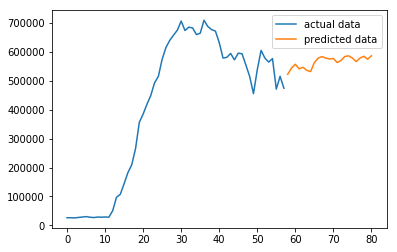

In [73]:
# making future prediction
flatten_state_data = tx_coal.reshape(-1)
val = flatten_state_data[-look_back:] # last batch in the training data
pred_list = []
for i in range(23): # predict the next 23 points
    pred = model.predict(val.reshape(1,1,look_back))
    pred_list = np.append(pred_list,pred)
    val = np.append(np.delete(val, 0), pred) # update the data batch to be fed in the next iteration
pred_list = pred_list.reshape(pred_list.shape[0],1)

# invert prediction
pred_list = scaler.inverse_transform(pred_list)

# plot
data_len = len(tx_coal)
print(data_len)
plt.plot(list(range(data_len)),scaler.inverse_transform(tx_coal),label="actual data")
plt.plot(list(range(data_len,data_len+len(pred_list))),pred_list,label="predicted data")
plt.legend()
plt.show()

Texas Coal production 1960-2040 dataframe

In [74]:
L = pred_list
L

array([[522550.17179244],
       [544314.22794474],
       [557226.14470336],
       [541444.89047118],
       [546851.29846155],
       [536332.89366091],
       [531857.55848079],
       [562785.93175004],
       [578576.31374753],
       [583835.82176499],
       [578724.47693796],
       [575510.89231569],
       [577148.83720083],
       [563293.54144838],
       [570080.11645187],
       [584040.62599906],
       [586467.22610629],
       [578763.92192375],
       [566541.06994788],
       [578571.66836698],
       [584898.35069524],
       [574852.47074503],
       [586504.75589132]])

In [75]:
tx_coal_pre = pd.DataFrame(L, columns=["Coal_prod"])
tx_coal_pre.head()

,Coal_prod
0,522550.171792
1,544314.227945
2,557226.144703
3,541444.890471
4,546851.298462


In [76]:
pre_yrs = numpy.arange(2018, 2041, 1).tolist()
pre_yrs = pd.DataFrame({"Years":pre_yrs})
pre_yrs.head()

,Years
0,2018
1,2019
2,2020
3,2021
4,2022


In [77]:

coal_pred = pd.concat([pre_yrs, tx_coal_pre], axis=1, sort=False)
coal_pred.head()

,Years,Coal_prod
0,2018,522550.171792
1,2019,544314.227945
2,2020,557226.144703
3,2021,541444.890471
4,2022,546851.298462


In [78]:
tx_coal = tx_energy[["Years", "Coal_prod"]]
tx_coal.head()

,Years,Coal_prod
0,1960,26409
1,1961,26535
2,1962,25855
3,1963,27441
4,1964,28839


In [79]:
TexasCoal_prod_pre = pd.concat([tx_coal, coal_pred])
TexasCoal_prod_pre.head()

,Years,Coal_prod
0,1960,26409.0
1,1961,26535.0
2,1962,25855.0
3,1963,27441.0
4,1964,28839.0


# Texas Gas Forcasting model

In [81]:
tx_gas = tx_energy[["Gas_prod"]]
tx_gas.head()

,Gas_prod
0,6602696
1,6682140
2,6812787
3,6952455
4,7311876


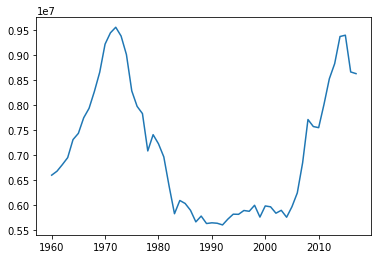

In [82]:
plt.plot(tx_energy.Years,tx_gas.Gas_prod)

In [83]:

scaler_tx_gas  = MinMaxScaler(feature_range=(0, 1))
tx_gas = scaler_tx_gas.fit_transform(tx_gas)

C:\Users\hocin\Anaconda\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [84]:
# split into train and test sets
train_size_tx_gas  = int(len(tx_gas ) * 0.67)
test_size_tx_gas  = len(tx_gas) - train_size_tx_gas 
train_tx_gas , test_tx_gas  = tx_gas [0:train_size_tx_gas,:], tx_gas [train_size_tx_gas :len(tx_gas),:]

In [85]:
# convert an array of values into a dataset matrix
def create_tx_gas(tx_gas, look_back=1):
	dataX_tx_gas, dataY_tx_gas = [], []
	for i_tx_gas in range(len(tx_gas)-look_back-1):
		a_tx_gas = tx_gas[i_tx_gas:(i_tx_gas+look_back), 0]
		dataX_tx_gas.append(a_tx_gas)
		dataY_tx_gas.append(tx_gas[i_tx_gas + look_back, 0])
	return numpy.array(dataX_tx_gas), numpy.array(dataY_tx_gas)

In [86]:
# reshape into X=t and Y=t+1
look_back = 1
trainX_tx_gas, trainY_tx_gas = create_tx_gas(train_tx_gas, look_back)
testX_tx_gas, testY_tx_gas = create_tx_gas(test_tx_gas, look_back)

In [87]:
# reshape input to be [samples, time steps, features]
trainX_tx_gas = numpy.reshape(trainX_tx_gas, (trainX_tx_gas.shape[0], 1, trainX_tx_gas.shape[1]))
testX_tx_gas = numpy.reshape(testX_tx_gas, (testX_tx_gas.shape[0], 1, testX_tx_gas.shape[1]))

In [88]:
# create and fit the LSTM network
model_tx_gas = Sequential()
model_tx_gas.add(LSTM(4, input_shape=(1, look_back)))
model_tx_gas.add(Dense(1))
model_tx_gas.compile(loss='mean_squared_error', optimizer='adam')
model_tx_gas.fit(trainX_tx_gas, trainY_tx_gas, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 3s - loss: 0.1830
Epoch 2/100
 - 0s - loss: 0.1474
Epoch 3/100
 - 0s - loss: 0.1198
Epoch 4/100
 - 0s - loss: 0.0983
Epoch 5/100
 - 0s - loss: 0.0838
Epoch 6/100
 - 0s - loss: 0.0720
Epoch 7/100
 - 0s - loss: 0.0645
Epoch 8/100
 - 0s - loss: 0.0588
Epoch 9/100
 - 0s - loss: 0.0550
Epoch 10/100
 - 0s - loss: 0.0507
Epoch 11/100
 - 0s - loss: 0.0479
Epoch 12/100
 - 0s - loss: 0.0450
Epoch 13/100
 - 0s - loss: 0.0425
Epoch 14/100
 - 0s - loss: 0.0397
Epoch 15/100
 - 0s - loss: 0.0376
Epoch 16/100
 - 0s - loss: 0.0350
Epoch 17/100
 - 0s - loss: 0.0326
Epoch 18/100
 - 0s - loss: 0.0303
Epoch 19/100
 - 0s - loss: 0.0282
Epoch 20/100
 - 0s - loss: 0.0260
Epoch 21/100
 - 0s - loss: 0.0243
Epoch 22/100
 - 0s - loss: 0.0223
Epoch 23/100
 - 0s - loss: 0.0205
Epoch 24/100
 - 0s - loss: 0.0188
Epoch 25/100
 - 0s - loss: 0.0173
Epoch 26/100
 - 0s - loss: 0.0159
Epoch 27/100
 - 0s - loss: 0.0146
Epoch 28/100
 - 0s - loss: 0.0136
Epoch 29/100
 - 0s - loss: 0.0123
Epoch 30/100
 - 0s - lo

In [89]:
# make predictions
trainPredict_tx_gas = model_tx_gas.predict(trainX_tx_gas)
testPredict_tx_gas = model_tx_gas.predict(testX_tx_gas)

In [90]:
# invert predictions
trainPredict_tx_gas = scaler_tx_gas.inverse_transform(trainPredict_tx_gas)
trainY_tx_gas = scaler_tx_gas.inverse_transform([trainY_tx_gas])
testPredict_tx_gas = scaler_tx_gas.inverse_transform(testPredict_tx_gas)
testY_tx_gas = scaler_tx_gas.inverse_transform([testY_tx_gas])
# calculate root mean squared error
trainScore_tx_gas = math.sqrt(mean_squared_error(trainY_tx_gas[0], trainPredict_tx_gas[:,0]))
print('Train Score: %.2f RMSE' % (trainScore_tx_gas))
testScore_tx_gas = math.sqrt(mean_squared_error(testY_tx_gas[0], testPredict_tx_gas[:,0]))
print('Test Score: %.2f RMSE' % (testScore_tx_gas))

Train Score: 303229.20 RMSE
Test Score: 400878.58 RMSE


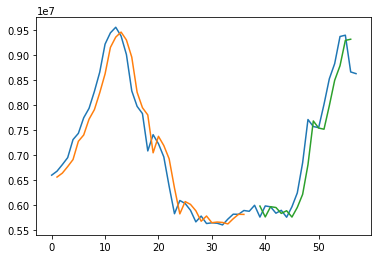

In [91]:
# shift train predictions for plotting
trainPredictPlot_tx_gas = numpy.empty_like(tx_gas)
trainPredictPlot_tx_gas[:, :] = numpy.nan
trainPredictPlot_tx_gas[look_back:len(trainPredict_tx_gas)+look_back, :] = trainPredict_tx_gas
# shift test predictions for plotting
testPredictPlot_tx_gas = numpy.empty_like(tx_gas)
testPredictPlot_tx_gas[:, :] = numpy.nan
testPredictPlot_tx_gas[len(trainPredict_tx_gas)+(look_back*2)+1:len(tx_gas)-1, :] = testPredict_tx_gas
# plot baseline and predictions
plt.plot(scaler_tx_gas.inverse_transform(tx_gas))
plt.plot(trainPredictPlot_tx_gas)
plt.plot(testPredictPlot_tx_gas)
plt.show()

In [92]:
# re-train the LSTM on all data
look_back = 30 # look back further
trainX_tx_gas, trainY_tx_gas = create_tx_gas(tx_gas, look_back)
trainX_tx_gas = numpy.reshape(trainX_tx_gas, (trainX_tx_gas.shape[0], 1, trainX_tx_gas.shape[1]))

# re-create and fit the LSTM network
model_tx_gas = Sequential()
model_tx_gas.add(LSTM(4, input_shape=(1, look_back)))
model_tx_gas.add(Dense(1))
model_tx_gas.compile(loss='mean_squared_error', optimizer='adam')
model_tx_gas.fit(trainX_tx_gas, trainY_tx_gas, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 3s - loss: 0.2102
Epoch 2/100
 - 0s - loss: 0.1794
Epoch 3/100
 - 0s - loss: 0.1559
Epoch 4/100
 - 0s - loss: 0.1368
Epoch 5/100
 - 0s - loss: 0.1198
Epoch 6/100
 - 0s - loss: 0.1038
Epoch 7/100
 - 0s - loss: 0.0902
Epoch 8/100
 - 0s - loss: 0.0771
Epoch 9/100
 - 0s - loss: 0.0653
Epoch 10/100
 - 0s - loss: 0.0557
Epoch 11/100
 - 0s - loss: 0.0459
Epoch 12/100
 - 0s - loss: 0.0378
Epoch 13/100
 - 0s - loss: 0.0314
Epoch 14/100
 - 0s - loss: 0.0257
Epoch 15/100
 - 0s - loss: 0.0216
Epoch 16/100
 - 0s - loss: 0.0179
Epoch 17/100
 - 0s - loss: 0.0154
Epoch 18/100
 - 0s - loss: 0.0133
Epoch 19/100
 - 0s - loss: 0.0120
Epoch 20/100
 - 0s - loss: 0.0107
Epoch 21/100
 - 0s - loss: 0.0100
Epoch 22/100
 - 0s - loss: 0.0094
Epoch 23/100
 - 0s - loss: 0.0087
Epoch 24/100
 - 0s - loss: 0.0085
Epoch 25/100
 - 0s - loss: 0.0079
Epoch 26/100
 - 0s - loss: 0.0078
Epoch 27/100
 - 0s - loss: 0.0073
Epoch 28/100
 - 0s - loss: 0.0072
Epoch 29/100
 - 0s - loss: 0.0070
Epoch 30/100
 - 0s - lo

58


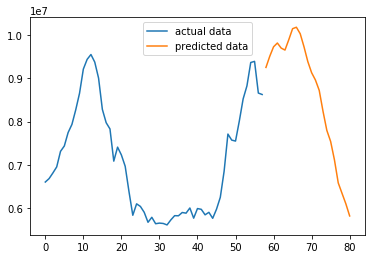

In [93]:
# making future prediction
flatten_tx_gas = tx_gas.reshape(-1)
val_tx_gas = flatten_tx_gas[-look_back:] # last batch in the training data
pred_list_tx_gas = []
for i_tx_gas in range(23): # predict the next 23 points
    pred_tx_gas = model_tx_gas.predict(val_tx_gas.reshape(1,1,look_back))
    pred_list_tx_gas = np.append(pred_list_tx_gas,pred_tx_gas)
    val_tx_gas = np.append(np.delete(val_tx_gas, 0),pred_tx_gas) # update the data batch to be fed in the next iteration
pred_list_tx_gas = pred_list_tx_gas.reshape(pred_list_tx_gas.shape[0],1)

# invert prediction
pred_list_tx_gas = scaler_tx_gas.inverse_transform(pred_list_tx_gas)

# plot
tx_gas_len = len(tx_gas)
print(tx_gas_len)
plt.plot(list(range(tx_gas_len)),scaler_tx_gas.inverse_transform(tx_gas),label="actual data")
plt.plot(list(range(tx_gas_len,tx_gas_len+len(pred_list_tx_gas))),pred_list_tx_gas,label="predicted data")
plt.legend()
plt.show()

texas gas production 1965-2040

In [98]:
L_gas = pred_list_tx_gas
tx_gas_pre = pd.DataFrame(L, columns=["Gas_prod"])
tx_gas_pre.head()
# pre_yrs = numpy.arange(2018, 2041, 1).tolist()
# pre_yrs = pd.DataFrame({"Years":pre_yrs})
# pre_yrs.head()
gas_pred = pd.concat([pre_yrs, tx_gas_pre], axis=1, sort=False)
gas_pred.head()
tx_gas = tx_energy[["Years", "Gas_prod"]]
tx_gas.head()
Texasgas_prod_pre = pd.concat([tx_gas, gas_pred])
Texasgas_prod_pre.head()

,Years,Gas_prod
0,1960,6602696.0
1,1961,6682140.0
2,1962,6812787.0
3,1963,6952455.0
4,1964,7311876.0


# Texas Oil Forcasting  model 

In [100]:
tx_oil = tx_energy[["Oil_prod"]]
tx_oil.head()

,Oil_prod
0,5379378
1,5447308
2,5471272
3,5671135
4,5739216


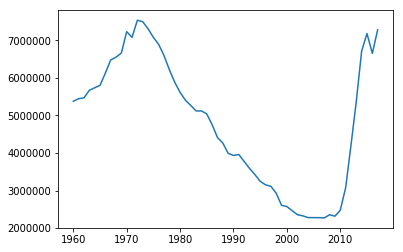

In [101]:
tx_oil = tx_energy[["Oil_prod"]]
tx_oil.head()
plt.plot(tx_energy.Years,tx_oil.Oil_prod)


In [102]:
scaler_tx_oil  = MinMaxScaler(feature_range=(0, 1))
tx_oil = scaler_tx_oil.fit_transform(tx_oil)

# split into train and test sets
train_size_tx_oil  = int(len(tx_oil) * 0.67)
test_size_tx_oil  = len(tx_oil) - train_size_tx_oil 
train_tx_oil , test_tx_oil  = tx_oil [0:train_size_tx_oil,:], tx_oil [train_size_tx_oil :len(tx_oil),:]

# convert an array of values into a dataset matrix
def create_tx_oil(tx_oil, look_back=1):
	dataX_tx_oil, dataY_tx_oil = [], []
	for i_tx_oil in range(len(tx_oil)-look_back-1):
		a_tx_oil = tx_oil[i_tx_oil:(i_tx_oil+look_back), 0]
		dataX_tx_oil.append(a_tx_oil)
		dataY_tx_oil.append(tx_oil[i_tx_oil + look_back, 0])
	return numpy.array(dataX_tx_oil), numpy.array(dataY_tx_oil)

# reshape into X=t and Y=t+1
look_back = 1
trainX_tx_oil, trainY_tx_oil = create_tx_oil(train_tx_oil, look_back)
testX_tx_oil, testY_tx_oil = create_tx_oil(test_tx_oil, look_back)


# reshape input to be [samples, time steps, features]
trainX_tx_oil = numpy.reshape(trainX_tx_oil, (trainX_tx_oil.shape[0], 1, trainX_tx_oil.shape[1]))
testX_tx_oil = numpy.reshape(testX_tx_oil, (testX_tx_oil.shape[0], 1, testX_tx_oil.shape[1]))

# create and fit the LSTM network
model_tx_oil = Sequential()
model_tx_oil.add(LSTM(4, input_shape=(1, look_back)))
model_tx_oil.add(Dense(1))
model_tx_oil.compile(loss='mean_squared_error', optimizer='adam')
model_tx_oil.fit(trainX_tx_oil, trainY_tx_oil, epochs=100, batch_size=1, verbose=2)

C:\Users\hocin\Anaconda\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Epoch 1/100
 - 4s - loss: 0.5306
Epoch 2/100
 - 0s - loss: 0.4423
Epoch 3/100
 - 0s - loss: 0.3690
Epoch 4/100
 - 0s - loss: 0.3079
Epoch 5/100
 - 0s - loss: 0.2544
Epoch 6/100
 - 0s - loss: 0.2099
Epoch 7/100
 - 0s - loss: 0.1694
Epoch 8/100
 - 0s - loss: 0.1368
Epoch 9/100
 - 0s - loss: 0.1092
Epoch 10/100
 - 0s - loss: 0.0885
Epoch 11/100
 - 0s - loss: 0.0728
Epoch 12/100
 - 0s - loss: 0.0616
Epoch 13/100
 - 0s - loss: 0.0544
Epoch 14/100
 - 0s - loss: 0.0495
Epoch 15/100
 - 0s - loss: 0.0462
Epoch 16/100
 - 0s - loss: 0.0445
Epoch 17/100
 - 0s - loss: 0.0426
Epoch 18/100
 - 0s - loss: 0.0413
Epoch 19/100
 - 0s - loss: 0.0404
Epoch 20/100
 - 0s - loss: 0.0396
Epoch 21/100
 - 0s - loss: 0.0390
Epoch 22/100
 - 0s - loss: 0.0378
Epoch 23/100
 - 0s - loss: 0.0370
Epoch 24/100
 - 0s - loss: 0.0363
Epoch 25/100
 - 0s - loss: 0.0355
Epoch 26/100
 - 0s - loss: 0.0344
Epoch 27/100
 - 0s - loss: 0.0336
Epoch 28/100
 - 0s - loss: 0.0328
Epoch 29/100
 - 0s - loss: 0.0320
Epoch 30/100
 - 0s - lo

In [103]:
# make predictions
trainPredict_tx_oil = model_tx_oil.predict(trainX_tx_oil)
testPredict_tx_oil = model_tx_oil.predict(testX_tx_oil)
# invert predictions
trainPredict_tx_oil = scaler_tx_oil.inverse_transform(trainPredict_tx_oil)
trainY_tx_oil = scaler_tx_oil.inverse_transform([trainY_tx_oil])
testPredict_tx_oil = scaler_tx_oil.inverse_transform(testPredict_tx_oil)
testY_tx_oil = scaler_tx_oil.inverse_transform([testY_tx_oil])
# calculate root mean squared error
trainScore_tx_oil = math.sqrt(mean_squared_error(trainY_tx_oil[0], trainPredict_tx_oil[:,0]))
print('Train Score: %.2f RMSE' % (trainScore_tx_oil))
testScore_tx_oil = math.sqrt(mean_squared_error(testY_tx_oil[0], testPredict_tx_oil[:,0]))
print('Test Score: %.2f RMSE' % (testScore_tx_oil))

Train Score: 216731.50 RMSE
Test Score: 595231.98 RMSE


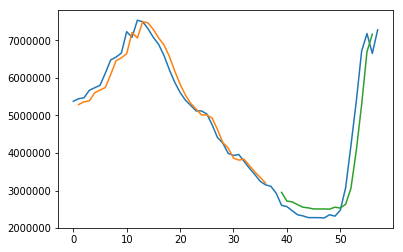

In [104]:
# shift train predictions for plotting
trainPredictPlot_tx_oil = numpy.empty_like(tx_oil)
trainPredictPlot_tx_oil[:, :] = numpy.nan
trainPredictPlot_tx_oil[look_back:len(trainPredict_tx_oil)+look_back, :] = trainPredict_tx_oil
# shift test predictions for plotting
testPredictPlot_tx_oil = numpy.empty_like(tx_oil)
testPredictPlot_tx_oil[:, :] = numpy.nan
testPredictPlot_tx_oil[len(trainPredict_tx_oil)+(look_back*2)+1:len(tx_oil)-1, :] = testPredict_tx_oil
# plot baseline and predictions
plt.plot(scaler_tx_oil.inverse_transform(tx_oil))
plt.plot(trainPredictPlot_tx_oil)
plt.plot(testPredictPlot_tx_oil)
plt.show()

In [105]:
# re-train the LSTM on all data
look_back = 30 # look back further
trainX_tx_oil, trainY_tx_oil = create_tx_gas(tx_oil, look_back)
trainX_tx_oil = numpy.reshape(trainX_tx_oil, (trainX_tx_oil.shape[0], 1, trainX_tx_oil.shape[1]))

# re-create and fit the LSTM network
model_tx_oil = Sequential()
model_tx_oil.add(LSTM(4, input_shape=(1, look_back)))
model_tx_oil.add(Dense(1))
model_tx_oil.compile(loss='mean_squared_error', optimizer='adam')
model_tx_oil.fit(trainX_tx_oil, trainY_tx_oil, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 4s - loss: 0.0701
Epoch 2/100
 - 0s - loss: 0.0627
Epoch 3/100
 - 0s - loss: 0.0578
Epoch 4/100
 - 0s - loss: 0.0524
Epoch 5/100
 - 0s - loss: 0.0489
Epoch 6/100
 - 0s - loss: 0.0453
Epoch 7/100
 - 0s - loss: 0.0396
Epoch 8/100
 - 0s - loss: 0.0353
Epoch 9/100
 - 0s - loss: 0.0311
Epoch 10/100
 - 0s - loss: 0.0274
Epoch 11/100
 - 0s - loss: 0.0252
Epoch 12/100
 - 0s - loss: 0.0222
Epoch 13/100
 - 0s - loss: 0.0196
Epoch 14/100
 - 0s - loss: 0.0194
Epoch 15/100
 - 0s - loss: 0.0166
Epoch 16/100
 - 0s - loss: 0.0143
Epoch 17/100
 - 0s - loss: 0.0154
Epoch 18/100
 - 0s - loss: 0.0127
Epoch 19/100
 - 0s - loss: 0.0127
Epoch 20/100
 - 0s - loss: 0.0122
Epoch 21/100
 - 0s - loss: 0.0111
Epoch 22/100
 - 0s - loss: 0.0106
Epoch 23/100
 - 0s - loss: 0.0101
Epoch 24/100
 - 0s - loss: 0.0113
Epoch 25/100
 - 0s - loss: 0.0092
Epoch 26/100
 - 0s - loss: 0.0106
Epoch 27/100
 - 0s - loss: 0.0088
Epoch 28/100
 - 0s - loss: 0.0082
Epoch 29/100
 - 0s - loss: 0.0086
Epoch 30/100
 - 0s - lo

58


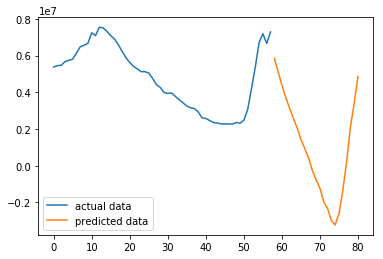

In [109]:
# making future prediction
flatten_tx_oil = tx_oil.reshape(-1)
val_tx_oil = flatten_tx_oil[-look_back:] # last batch in the training data
pred_list_tx_oil = []
for i_tx_oil in range(23): # predict the next 23 points
    pred_tx_oil = model_tx_oil.predict(val_tx_oil.reshape(1,1,look_back))
    pred_list_tx_oil = np.append(pred_list_tx_oil,pred_tx_oil)
    val_tx_oil = np.append(np.delete(val_tx_oil, 0),pred_tx_oil) # update the data batch to be fed in the next iteration
pred_list_tx_oil = pred_list_tx_oil.reshape(pred_list_tx_oil.shape[0],1)

# invert prediction
pred_list_tx_oil = scaler_tx_oil.inverse_transform(pred_list_tx_oil)

# plot
tx_oil_len = len(tx_oil)
print(tx_oil_len)
plt.plot(list(range(tx_oil_len)),scaler_tx_oil.inverse_transform(tx_oil),label="actual data")
plt.plot(list(range(tx_oil_len,tx_oil_len+len(pred_list_tx_oil))),pred_list_tx_oil,label="predicted data")
plt.legend()
plt.show()

texas crude oil production 1965-2040

In [113]:
L_oil = pred_list_tx_oil
tx_oil_pre = pd.DataFrame(L, columns=["Oil_prod"])
# tx_oil_pre.head()
# pre_yrs = numpy.arange(2018, 2041, 1).tolist()
# pre_yrs = pd.DataFrame({"Years":pre_yrs})
# pre_yrs.head()
oil_pred = pd.concat([pre_yrs, tx_oil_pre], axis=1, sort=False)
gas_pred.head()
tx_oil = tx_energy[["Years", "Oil_prod"]]
tx_oil.head()
TexasOil_prod_pre = pd.concat([tx_oil, oil_pred])
TexasOil_prod_pre.head()

,Years,Oil_prod
0,1960,5379378.0
1,1961,5447308.0
2,1962,5471272.0
3,1963,5671135.0
4,1964,5739216.0


# Texas Renewable_en_prod  Forcasting model 

In [117]:
tx_Renewable = tx_energy[["Renewable_en_prod"]]
tx_Renewable.head()


,Renewable_en_prod
0,50155
1,52023
2,47721
3,42718
4,43884


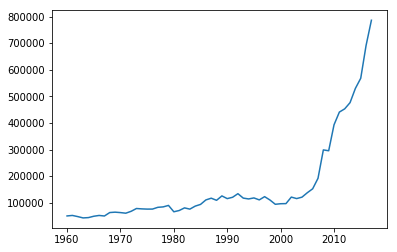

In [119]:
plt.plot(tx_energy.Years,tx_Renewable.Renewable_en_prod)

In [121]:
scaler_tx_Renewable  = MinMaxScaler(feature_range=(0, 1))
tx_Renewable = scaler_tx_Renewable.fit_transform(tx_Renewable)

# split into train and test sets
train_size_tx_Renewable  = int(len(tx_Renewable) * 0.67)
test_size_tx_Renewable  = len(tx_Renewable) - train_size_tx_Renewable 
train_tx_Renewable , test_tx_Renewable  = tx_Renewable [0:train_size_tx_Renewable,:], tx_Renewable [train_size_tx_Renewable :len(tx_Renewable),:]

# convert an array of values into a dataset matrix
def create_tx_Renewable(tx_Renewable, look_back=1):
	dataX_tx_Renewable, dataY_tx_Renewable = [], []
	for i_tx_Renewable in range(len(tx_Renewable)-look_back-1):
		a_tx_Renewable = tx_Renewable[i_tx_Renewable:(i_tx_Renewable+look_back), 0]
		dataX_tx_Renewable.append(a_tx_Renewable)
		dataY_tx_Renewable.append(tx_Renewable[i_tx_Renewable + look_back, 0])
	return numpy.array(dataX_tx_Renewable), numpy.array(dataY_tx_Renewable)

# reshape into X=t and Y=t+1
look_back = 1
trainX_tx_Renewable, trainY_tx_Renewable = create_tx_Renewable(train_tx_Renewable, look_back)
testX_tx_Renewable, testY_tx_Renewable = create_tx_Renewable(test_tx_Renewable, look_back)


# reshape input to be [samples, time steps, features]
trainX_tx_Renewable = numpy.reshape(trainX_tx_Renewable, (trainX_tx_Renewable.shape[0], 1, trainX_tx_Renewable.shape[1]))
testX_tx_Renewable = numpy.reshape(testX_tx_Renewable, (testX_tx_Renewable.shape[0], 1, testX_tx_Renewable.shape[1]))

# create and fit the LSTM network
model_tx_Renewable = Sequential()
model_tx_Renewable.add(LSTM(4, input_shape=(1, look_back)))
model_tx_Renewable.add(Dense(1))
model_tx_Renewable.compile(loss='mean_squared_error', optimizer='adam')
model_tx_Renewable.fit(trainX_tx_Renewable, trainY_tx_Renewable, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 4s - loss: 0.0018
Epoch 2/100
 - 0s - loss: 9.5210e-04
Epoch 3/100
 - 0s - loss: 8.9682e-04
Epoch 4/100
 - 0s - loss: 8.8199e-04
Epoch 5/100
 - 0s - loss: 8.5283e-04
Epoch 6/100
 - 0s - loss: 8.1864e-04
Epoch 7/100
 - 0s - loss: 8.1616e-04
Epoch 8/100
 - 0s - loss: 8.1730e-04
Epoch 9/100
 - 0s - loss: 7.7404e-04
Epoch 10/100
 - 0s - loss: 7.6709e-04
Epoch 11/100
 - 0s - loss: 6.8620e-04
Epoch 12/100
 - 0s - loss: 6.6724e-04
Epoch 13/100
 - 0s - loss: 6.3118e-04
Epoch 14/100
 - 0s - loss: 6.1929e-04
Epoch 15/100
 - 0s - loss: 6.0205e-04
Epoch 16/100
 - 0s - loss: 5.5292e-04
Epoch 17/100
 - 0s - loss: 5.1982e-04
Epoch 18/100
 - 0s - loss: 4.8779e-04
Epoch 19/100
 - 0s - loss: 4.8008e-04
Epoch 20/100
 - 0s - loss: 4.2899e-04
Epoch 21/100
 - 0s - loss: 4.0616e-04
Epoch 22/100
 - 0s - loss: 3.9391e-04
Epoch 23/100
 - 0s - loss: 3.7795e-04
Epoch 24/100
 - 0s - loss: 3.4662e-04
Epoch 25/100
 - 0s - loss: 3.2586e-04
Epoch 26/100
 - 0s - loss: 2.9948e-04
Epoch 27/100
 - 0s - loss

In [122]:
# make predictions
trainPredict_tx_Renewable = model_tx_Renewable.predict(trainX_tx_Renewable)
testPredict_tx_Renewable = model_tx_Renewable.predict(testX_tx_Renewable)
# invert predictions
trainPredict_tx_Renewable = scaler_tx_Renewable.inverse_transform(trainPredict_tx_Renewable)
trainY_tx_Renewable = scaler_tx_Renewable.inverse_transform([trainY_tx_Renewable])
testPredict_tx_Renewable = scaler_tx_Renewable.inverse_transform(testPredict_tx_Renewable)
testY_tx_Renewable = scaler_tx_Renewable.inverse_transform([testY_tx_Renewable])
# calculate root mean squared error
trainScore_tx_Renewable = math.sqrt(mean_squared_error(trainY_tx_Renewable[0], trainPredict_tx_Renewable[:,0]))
print('Train Score: %.2f RMSE' % (trainScore_tx_Renewable))
testScore_tx_Renewable = math.sqrt(mean_squared_error(testY_tx_Renewable[0], testPredict_tx_Renewable[:,0]))
print('Test Score: %.2f RMSE' % (testScore_tx_Renewable))

Train Score: 0.01 RMSE
Test Score: 0.08 RMSE


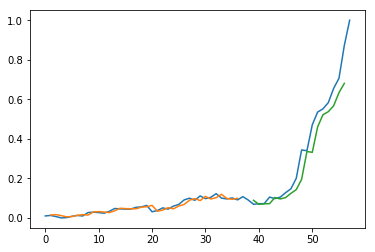

In [123]:
# shift train predictions for plotting
trainPredictPlot_tx_Renewable = numpy.empty_like(tx_Renewable)
trainPredictPlot_tx_Renewable[:, :] = numpy.nan
trainPredictPlot_tx_Renewable[look_back:len(trainPredict_tx_Renewable)+look_back, :] = trainPredict_tx_Renewable
# shift test predictions for plotting
testPredictPlot_tx_Renewable = numpy.empty_like(tx_Renewable)
testPredictPlot_tx_Renewable[:, :] = numpy.nan
testPredictPlot_tx_Renewable[len(trainPredict_tx_Renewable)+(look_back*2)+1:len(tx_Renewable)-1, :] = testPredict_tx_Renewable
# plot baseline and predictions
plt.plot(scaler_tx_Renewable.inverse_transform(tx_Renewable))
plt.plot(trainPredictPlot_tx_Renewable)
plt.plot(testPredictPlot_tx_Renewable)
plt.show()

In [124]:
# re-train the LSTM on all data
look_back = 30 # look back further
trainX_tx_Renewable, trainY_tx_Renewable = create_tx_Renewable(tx_Renewable, look_back)
trainX_tx_Renewable = numpy.reshape(trainX_tx_Renewable, (trainX_tx_Renewable.shape[0], 1, trainX_tx_Renewable.shape[1]))

# re-create and fit the LSTM network
model_tx_Renewable = Sequential()
model_tx_Renewable.add(LSTM(4, input_shape=(1, look_back)))
model_tx_Renewable.add(Dense(1))
model_tx_Renewable.compile(loss='mean_squared_error', optimizer='adam')
model_tx_Renewable.fit(trainX_tx_Renewable, trainY_tx_Renewable, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 4s - loss: 0.1330
Epoch 2/100
 - 0s - loss: 0.1121
Epoch 3/100
 - 0s - loss: 0.0954
Epoch 4/100
 - 0s - loss: 0.0809
Epoch 5/100
 - 0s - loss: 0.0665
Epoch 6/100
 - 0s - loss: 0.0550
Epoch 7/100
 - 0s - loss: 0.0462
Epoch 8/100
 - 0s - loss: 0.0384
Epoch 9/100
 - 0s - loss: 0.0344
Epoch 10/100
 - 0s - loss: 0.0307
Epoch 11/100
 - 0s - loss: 0.0280
Epoch 12/100
 - 0s - loss: 0.0260
Epoch 13/100
 - 0s - loss: 0.0244
Epoch 14/100
 - 0s - loss: 0.0228
Epoch 15/100
 - 0s - loss: 0.0211
Epoch 16/100
 - 0s - loss: 0.0196
Epoch 17/100
 - 0s - loss: 0.0181
Epoch 18/100
 - 0s - loss: 0.0167
Epoch 19/100
 - 0s - loss: 0.0154
Epoch 20/100
 - 0s - loss: 0.0140
Epoch 21/100
 - 0s - loss: 0.0130
Epoch 22/100
 - 0s - loss: 0.0116
Epoch 23/100
 - 0s - loss: 0.0106
Epoch 24/100
 - 0s - loss: 0.0097
Epoch 25/100
 - 0s - loss: 0.0088
Epoch 26/100
 - 0s - loss: 0.0079
Epoch 27/100
 - 0s - loss: 0.0072
Epoch 28/100
 - 0s - loss: 0.0067
Epoch 29/100
 - 0s - loss: 0.0060
Epoch 30/100
 - 0s - lo

58


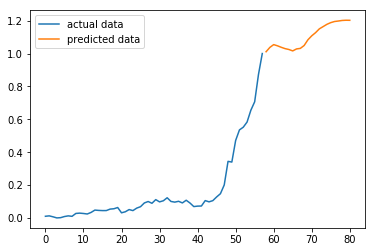

In [125]:
# re-train the LSTM on all data
look_back = 30 # look back further
trainX_tx_Renewable, trainY_tx_Renewable = create_tx_Renewable(tx_Renewable, look_back)
trainX_tx_Renewable = numpy.reshape(trainX_tx_Renewable, (trainX_tx_Renewable.shape[0], 1, trainX_tx_Renewable.shape[1]))

# re-create and fit the LSTM network
model_tx_Renewable = Sequential()
model_tx_Renewable.add(LSTM(4, input_shape=(1, look_back)))
model_tx_Renewable.add(Dense(1))
model_tx_Renewable.compile(loss='mean_squared_error', optimizer='adam')
model_tx_Renewable.fit(trainX_tx_Renewable, trainY_tx_Renewable, epochs=100, batch_size=1, verbose=2)


# making future prediction
flatten_tx_Renewable = tx_Renewable.reshape(-1)
val_tx_Renewable = flatten_tx_Renewable[-look_back:] # last batch in the training data
pred_list_tx_Renewable = []
for i_tx_Renewable in range(23): # predict the next 23 points
    pred_tx_Renewable = model_tx_Renewable.predict(val_tx_Renewable.reshape(1,1,look_back))
    pred_list_tx_Renewable = np.append(pred_list_tx_Renewable,pred_tx_Renewable)
    val_tx_Renewable = np.append(np.delete(val_tx_Renewable, 0),pred_tx_Renewable) # update the data batch to be fed in the next iteration
pred_list_tx_Renewable = pred_list_tx_Renewable.reshape(pred_list_tx_Renewable.shape[0],1)

# invert prediction
pred_list_tx_Renewable = scaler_tx_Renewable.inverse_transform(pred_list_tx_Renewable)

# plot
tx_Renewable_len = len(tx_Renewable)
print(tx_oil_len)
plt.plot(list(range(tx_Renewable_len)),scaler_tx_Renewable.inverse_transform(tx_Renewable),label="actual data")
plt.plot(list(range(tx_Renewable_len,tx_Renewable_len+len(pred_list_tx_Renewable))),pred_list_tx_Renewable,label="predicted data")
plt.legend()
plt.show()

texas renewable energy production 1965-2040

In [129]:
L_Renewable = pred_list_tx_Renewable
tx_Renewable_pre = pd.DataFrame(L, columns=["Renewable_en_prod"])
# tx_Renewable_pre.head()
# pre_yrs = numpy.arange(2018, 2041, 1).tolist()
# pre_yrs = pd.DataFrame({"Years":pre_yrs})
# pre_yrs.head()
Renewable_pred = pd.concat([pre_yrs, tx_Renewable_pre], axis=1, sort=False)
Renewable_pred.head()
tx_Renewable = tx_energy[["Years", "Renewable_en_prod"]]
tx_Renewable.head()
TexasRenewable_prod_pre = pd.concat([tx_Renewable, Renewable_pred])
TexasRenewable_prod_pre.head()

,Years,Renewable_en_prod
0,1960,50155.0
1,1961,52023.0
2,1962,47721.0
3,1963,42718.0
4,1964,43884.0


# Texas Total Energy production Forcasting model 

In [131]:
tx_TotalEnergy= tx_energy[["Total_en_prod"]]
tx_TotalEnergy.head()

,Total_en_prod
0,12058639
1,12208006
2,12357635
3,12693749
4,13123816


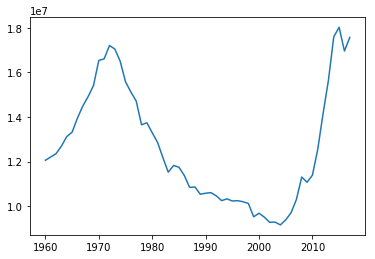

In [133]:
tx_TotalEnergy= tx_energy[["Total_en_prod"]]
tx_TotalEnergy.head()
plt.plot(tx_energy.Years,tx_TotalEnergy.Total_en_prod)

In [135]:
scaler_tx_TotalEnergy  = MinMaxScaler(feature_range=(0, 1))
tx_TotalEnergy = scaler_tx_TotalEnergy.fit_transform(tx_TotalEnergy)

# split into train and test sets
train_size_tx_TotalEnergy  = int(len(tx_TotalEnergy) * 0.67)
test_size_tx_TotalEnergy  = len(tx_TotalEnergy) - train_size_tx_TotalEnergy 
train_tx_TotalEnergy , test_tx_TotalEnergy  = tx_TotalEnergy [0:train_size_tx_TotalEnergy,:], tx_TotalEnergy [train_size_tx_TotalEnergy :len(tx_TotalEnergy),:]

# convert an array of values into a dataset matrix
def create_tx_TotalEnergy(tx_TotalEnergy, look_back=1):
	dataX_tx_TotalEnergy, dataY_tx_TotalEnergy = [], []
	for i_tx_TotalEnergy in range(len(tx_TotalEnergy)-look_back-1):
		a_tx_TotalEnergy = tx_TotalEnergy[i_tx_TotalEnergy:(i_tx_TotalEnergy+look_back), 0]
		dataX_tx_TotalEnergy.append(a_tx_TotalEnergy)
		dataY_tx_TotalEnergy.append(tx_TotalEnergy[i_tx_TotalEnergy + look_back, 0])
	return numpy.array(dataX_tx_TotalEnergy), numpy.array(dataY_tx_TotalEnergy)

# reshape into X=t and Y=t+1
look_back = 1
trainX_tx_TotalEnergy, trainY_tx_TotalEnergy = create_tx_TotalEnergy(train_tx_TotalEnergy, look_back)
testX_tx_TotalEnergy, testY_tx_TotalEnergy = create_tx_TotalEnergy(test_tx_TotalEnergy, look_back)


# reshape input to be [samples, time steps, features]
trainX_tx_TotalEnergy = numpy.reshape(trainX_tx_TotalEnergy, (trainX_tx_TotalEnergy.shape[0], 1, trainX_tx_TotalEnergy.shape[1]))
testX_tx_TotalEnergy = numpy.reshape(testX_tx_TotalEnergy, (testX_tx_TotalEnergy.shape[0], 1, testX_tx_TotalEnergy.shape[1]))

# create and fit the LSTM network
model_tx_TotalEnergy = Sequential()
model_tx_TotalEnergy.add(LSTM(4, input_shape=(1, look_back)))
model_tx_TotalEnergy.add(Dense(1))
model_tx_TotalEnergy.compile(loss='mean_squared_error', optimizer='adam')
model_tx_TotalEnergy.fit(trainX_tx_TotalEnergy, trainY_tx_TotalEnergy, epochs=100, batch_size=1, verbose=2)

C:\Users\hocin\Anaconda\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Epoch 1/100
 - 4s - loss: 0.1880
Epoch 2/100
 - 0s - loss: 0.1529
Epoch 3/100
 - 0s - loss: 0.1210
Epoch 4/100
 - 0s - loss: 0.0953
Epoch 5/100
 - 0s - loss: 0.0738
Epoch 6/100
 - 0s - loss: 0.0587
Epoch 7/100
 - 0s - loss: 0.0477
Epoch 8/100
 - 0s - loss: 0.0406
Epoch 9/100
 - 0s - loss: 0.0363
Epoch 10/100
 - 0s - loss: 0.0332
Epoch 11/100
 - 0s - loss: 0.0313
Epoch 12/100
 - 0s - loss: 0.0303
Epoch 13/100
 - 0s - loss: 0.0286
Epoch 14/100
 - 0s - loss: 0.0276
Epoch 15/100
 - 0s - loss: 0.0266
Epoch 16/100
 - 0s - loss: 0.0255
Epoch 17/100
 - 0s - loss: 0.0244
Epoch 18/100
 - 0s - loss: 0.0233
Epoch 19/100
 - 0s - loss: 0.0224
Epoch 20/100
 - 0s - loss: 0.0216
Epoch 21/100
 - 0s - loss: 0.0202
Epoch 22/100
 - 0s - loss: 0.0191
Epoch 23/100
 - 0s - loss: 0.0180
Epoch 24/100
 - 0s - loss: 0.0170
Epoch 25/100
 - 0s - loss: 0.0160
Epoch 26/100
 - 0s - loss: 0.0151
Epoch 27/100
 - 0s - loss: 0.0143
Epoch 28/100
 - 0s - loss: 0.0133
Epoch 29/100
 - 0s - loss: 0.0123
Epoch 30/100
 - 0s - lo

Train Score: 458600.54 RMSE
Test Score: 871012.20 RMSE


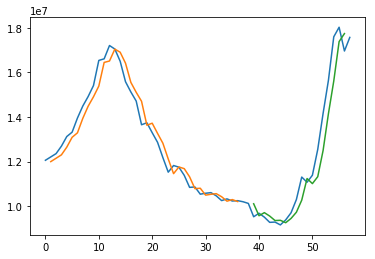

In [136]:
# make predictions
trainPredict_tx_TotalEnergy = model_tx_TotalEnergy.predict(trainX_tx_TotalEnergy)
testPredict_tx_TotalEnergy = model_tx_TotalEnergy.predict(testX_tx_TotalEnergy)
# invert predictions
trainPredict_tx_TotalEnergy = scaler_tx_TotalEnergy.inverse_transform(trainPredict_tx_TotalEnergy)
trainY_tx_TotalEnergy = scaler_tx_TotalEnergy.inverse_transform([trainY_tx_TotalEnergy])
testPredict_tx_TotalEnergy = scaler_tx_TotalEnergy.inverse_transform(testPredict_tx_TotalEnergy)
testY_tx_TotalEnergy = scaler_tx_TotalEnergy.inverse_transform([testY_tx_TotalEnergy])
# calculate root mean squared error
trainScore_tx_TotalEnergy = math.sqrt(mean_squared_error(trainY_tx_TotalEnergy[0], trainPredict_tx_TotalEnergy[:,0]))
print('Train Score: %.2f RMSE' % (trainScore_tx_TotalEnergy))
testScore_tx_TotalEnergy = math.sqrt(mean_squared_error(testY_tx_TotalEnergy[0], testPredict_tx_TotalEnergy[:,0]))
print('Test Score: %.2f RMSE' % (testScore_tx_TotalEnergy))

# shift train predictions for plotting
trainPredictPlot_tx_TotalEnergy = numpy.empty_like(tx_TotalEnergy)
trainPredictPlot_tx_TotalEnergy[:, :] = numpy.nan
trainPredictPlot_tx_TotalEnergy[look_back:len(trainPredict_tx_TotalEnergy)+look_back, :] = trainPredict_tx_TotalEnergy
# shift test predictions for plotting
testPredictPlot_tx_TotalEnergy = numpy.empty_like(tx_TotalEnergy)
testPredictPlot_tx_TotalEnergy[:, :] = numpy.nan
testPredictPlot_tx_TotalEnergy[len(trainPredict_tx_TotalEnergy)+(look_back*2)+1:len(tx_TotalEnergy)-1, :] = testPredict_tx_TotalEnergy
# plot baseline and predictions
plt.plot(scaler_tx_TotalEnergy.inverse_transform(tx_TotalEnergy))
plt.plot(trainPredictPlot_tx_TotalEnergy)
plt.plot(testPredictPlot_tx_TotalEnergy)
plt.show()

Epoch 1/100
 - 5s - loss: 0.1503
Epoch 2/100
 - 0s - loss: 0.1340
Epoch 3/100
 - 0s - loss: 0.1237
Epoch 4/100
 - 0s - loss: 0.1150
Epoch 5/100
 - 0s - loss: 0.1076
Epoch 6/100
 - 0s - loss: 0.0982
Epoch 7/100
 - 0s - loss: 0.0911
Epoch 8/100
 - 0s - loss: 0.0847
Epoch 9/100
 - 0s - loss: 0.0765
Epoch 10/100
 - 0s - loss: 0.0707
Epoch 11/100
 - 0s - loss: 0.0646
Epoch 12/100
 - 0s - loss: 0.0576
Epoch 13/100
 - 0s - loss: 0.0527
Epoch 14/100
 - 0s - loss: 0.0473
Epoch 15/100
 - 0s - loss: 0.0426
Epoch 16/100
 - 0s - loss: 0.0382
Epoch 17/100
 - 0s - loss: 0.0343
Epoch 18/100
 - 0s - loss: 0.0307
Epoch 19/100
 - 0s - loss: 0.0278
Epoch 20/100
 - 0s - loss: 0.0246
Epoch 21/100
 - 0s - loss: 0.0223
Epoch 22/100
 - 0s - loss: 0.0202
Epoch 23/100
 - 0s - loss: 0.0182
Epoch 24/100
 - 0s - loss: 0.0162
Epoch 25/100
 - 0s - loss: 0.0150
Epoch 26/100
 - 0s - loss: 0.0139
Epoch 27/100
 - 0s - loss: 0.0126
Epoch 28/100
 - 0s - loss: 0.0116
Epoch 29/100
 - 0s - loss: 0.0108
Epoch 30/100
 - 0s - lo

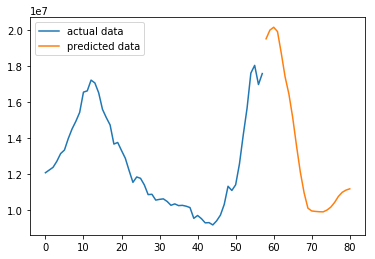

In [137]:
# re-train the LSTM on all data
look_back = 30 # look back further
trainX_tx_TotalEnergy, trainY_tx_TotalEnergy = create_tx_TotalEnergy(tx_TotalEnergy, look_back)
trainX_tx_TotalEnergy = numpy.reshape(trainX_tx_TotalEnergy, (trainX_tx_TotalEnergy.shape[0], 1, trainX_tx_TotalEnergy.shape[1]))

# re-create and fit the LSTM network
model_tx_TotalEnergy = Sequential()
model_tx_TotalEnergy.add(LSTM(4, input_shape=(1, look_back)))
model_tx_TotalEnergy.add(Dense(1))
model_tx_TotalEnergy.compile(loss='mean_squared_error', optimizer='adam')
model_tx_TotalEnergy.fit(trainX_tx_TotalEnergy, trainY_tx_TotalEnergy, epochs=100, batch_size=1, verbose=2)


# making future prediction
flatten_tx_TotalEnergy = tx_TotalEnergy.reshape(-1)
val_tx_TotalEnergy = flatten_tx_TotalEnergy[-look_back:] # last batch in the training data
pred_list_tx_TotalEnergy = []
for i_tx_TotalEnergy in range(23): # predict the next 23 points
    pred_tx_TotalEnergy = model_tx_TotalEnergy.predict(val_tx_TotalEnergy.reshape(1,1,look_back))
    pred_list_tx_TotalEnergy = np.append(pred_list_tx_TotalEnergy,pred_tx_TotalEnergy)
    val_tx_TotalEnergy = np.append(np.delete(val_tx_TotalEnergy, 0),pred_tx_TotalEnergy) # update the data batch to be fed in the next iteration
pred_list_tx_TotalEnergy = pred_list_tx_TotalEnergy.reshape(pred_list_tx_TotalEnergy.shape[0],1)

# invert prediction
pred_list_tx_TotalEnergy = scaler_tx_TotalEnergy.inverse_transform(pred_list_tx_TotalEnergy)

# plot
tx_TotalEnergy_len = len(tx_TotalEnergy)
print(tx_oil_len)
plt.plot(list(range(tx_TotalEnergy_len)),scaler_tx_TotalEnergy.inverse_transform(tx_TotalEnergy),label="actual data")
plt.plot(list(range(tx_TotalEnergy_len,tx_TotalEnergy_len+len(pred_list_tx_TotalEnergy))),pred_list_tx_TotalEnergy,label="predicted data")
plt.legend()
plt.show()

In [142]:
L_TotalEnergy = pred_list_tx_TotalEnergy
tx_TotalEnergy_pre = pd.DataFrame(L, columns=["Total_en_prod"])
# tx_TotalEnergy_pre.head()
# pre_yrs = numpy.arange(2018, 2041, 1).tolist()
# pre_yrs = pd.DataFrame({"Years":pre_yrs})
# pre_yrs.head()
TotalEnergy_pred = pd.concat([pre_yrs, tx_TotalEnergy_pre], axis=1, sort=False)
TotalEnergy_pred.head()
tx_TotalEnergy = tx_energy[["Years", "Total_en_prod"]]
tx_TotalEnergy.head()
TexasTotalEnergy_prod_pre = pd.concat([tx_TotalEnergy, TotalEnergy_pred])
TexasTotalEnergy_prod_pre.head()

,Years,Total_en_prod
0,1960,12058639.0
1,1961,12208006.0
2,1962,12357635.0
3,1963,12693749.0
4,1964,13123816.0
